In [ ]:
# Install dependencies
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!git clone https://github.com/facebookresearch/detectron2.git
!pip install -e detectron2
!pip install -U opencv-python
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-keyring_1.1-1_all.deb
!sudo dpkg -i cuda-keyring_1.1-1_all.deb
!sudo apt-get update
!sudo apt-get -y install cuda-toolkit-12-3

In [ ]:
# Build mask2former
!export CUDA_HOME=/usr/local/cuda
%cd mask2former/modeling/pixel_decoder/ops
!pip install -e .
%cd ../../../../

In [ ]:
# Download Checkpoint
!pip install gdown
!gdown 1mlLYq8ADU7hDyKQdzCtXAkMb7tKIPO-H

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2anomaly")

# import some common libraries
import numpy as np
import cv2
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
# import Mask2Former project
from mask2former import add_maskformer2_config
from matplotlib import pyplot as plt

cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)

# cityscapes
cfg.merge_from_file("configs/cityscapes/semantic-segmentation/anomaly_inference.yaml")
cfg.MODEL.WEIGHTS = 'checkpoints/model_final6.pth'

# streethazard
# cfg.merge_from_file("configs/streethazard/streethazard_inference.yaml")
# cfg.MODEL.WEIGHTS = 'best_model_streethazard.pth'

predictor = DefaultPredictor(cfg)

Loading config configs/cityscapes/semantic-segmentation/Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[03/04 18:10:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from checkpoints/model_final6.pth ...


In [7]:
def pred(im_path):
    im = cv2.imread(im_path)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    outputs = predictor(im)

    # Show anomaly segmentation predictions:
    anomaly_map = outputs["sem_seg"].unsqueeze(0)
    anomaly_map = 1 - torch.max(anomaly_map[0:19,:,:], axis = 1)[0]
    if outputs["sem_seg"][19:,:,:].shape[0] > 1:
        outputs_na_mask = torch.max(outputs["sem_seg"][19:,:,:].unsqueeze(0),  axis = 1)[0]
        outputs_na_mask[outputs_na_mask < 0.5] = 0
        outputs_na_mask[outputs_na_mask >= 0.5] = 1
        outputs_na_mask = 1 - outputs_na_mask
        anomaly_map = anomaly_map*outputs_na_mask.detach()
    anomaly_map = anomaly_map.detach().cpu().numpy().squeeze().squeeze()

    anomaly_map[anomaly_map<0.95] = 0
    anomaly_map_normalized = (anomaly_map * 255.0).astype(np.uint8)
    # Apply color map
    colored_map = cv2.applyColorMap(anomaly_map_normalized, cv2.COLORMAP_JET)
    # Convert to RGB (OpenCV uses BGR by default)
    colored_map_rgb = cv2.cvtColor(colored_map, cv2.COLOR_BGR2RGB)

    # Custom alpha value (0.0 to 1.0, where 1.0 is fully opaque)
    custom_alpha = 0.5  # Example: 50% opacity

    # Create a mask where anomaly_map is not 0
    mask = anomaly_map_normalized > 0

    # Create alpha channel based on the custom_alpha value
    # For regions with anomalies (mask == True), set alpha to custom_alpha; otherwise, fully transparent
    alpha_channel = np.zeros_like(anomaly_map_normalized, dtype=np.float32)
    alpha_channel[mask] = custom_alpha * 255  # Scale alpha to 0-255 range

    # Ensure the original image is in RGBA format with a fully opaque alpha channel
    im_rgba = np.dstack((im_rgb, np.ones(im_rgb.shape[:2], dtype=np.uint8) * 255))

    # Convert alpha_channel to the same shape as im_rgba for broadcasting
    alpha_channel_3d = np.repeat(alpha_channel[:, :, np.newaxis], 4, axis=2)
    alpha_channel_3d[..., 3] = 255  # Keep the alpha channel of the overlay fully opaque

    # Prepare the colored map in RGBA format
    colored_map_rgba = np.dstack((colored_map_rgb, np.ones(colored_map_rgb.shape[:2], dtype=np.uint8) * 255))

    # Blend the images based on the alpha mask
    blended_image = im_rgba * (1 - alpha_channel_3d / 255) + colored_map_rgba * (alpha_channel_3d / 255)

    # Since the alpha channel in the result is not needed for display, convert it back to RGB
    blended_image_rgb = blended_image[..., :3].astype(np.uint8)
    return blended_image_rgb

In [8]:
im_path = "./data/IMG_20240226_180027.jpg"
im = cv2.imread(im_path)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
outputs = predictor(im)

# Show anomaly segmentation predictions:
anomaly_map = outputs["sem_seg"].unsqueeze(0)

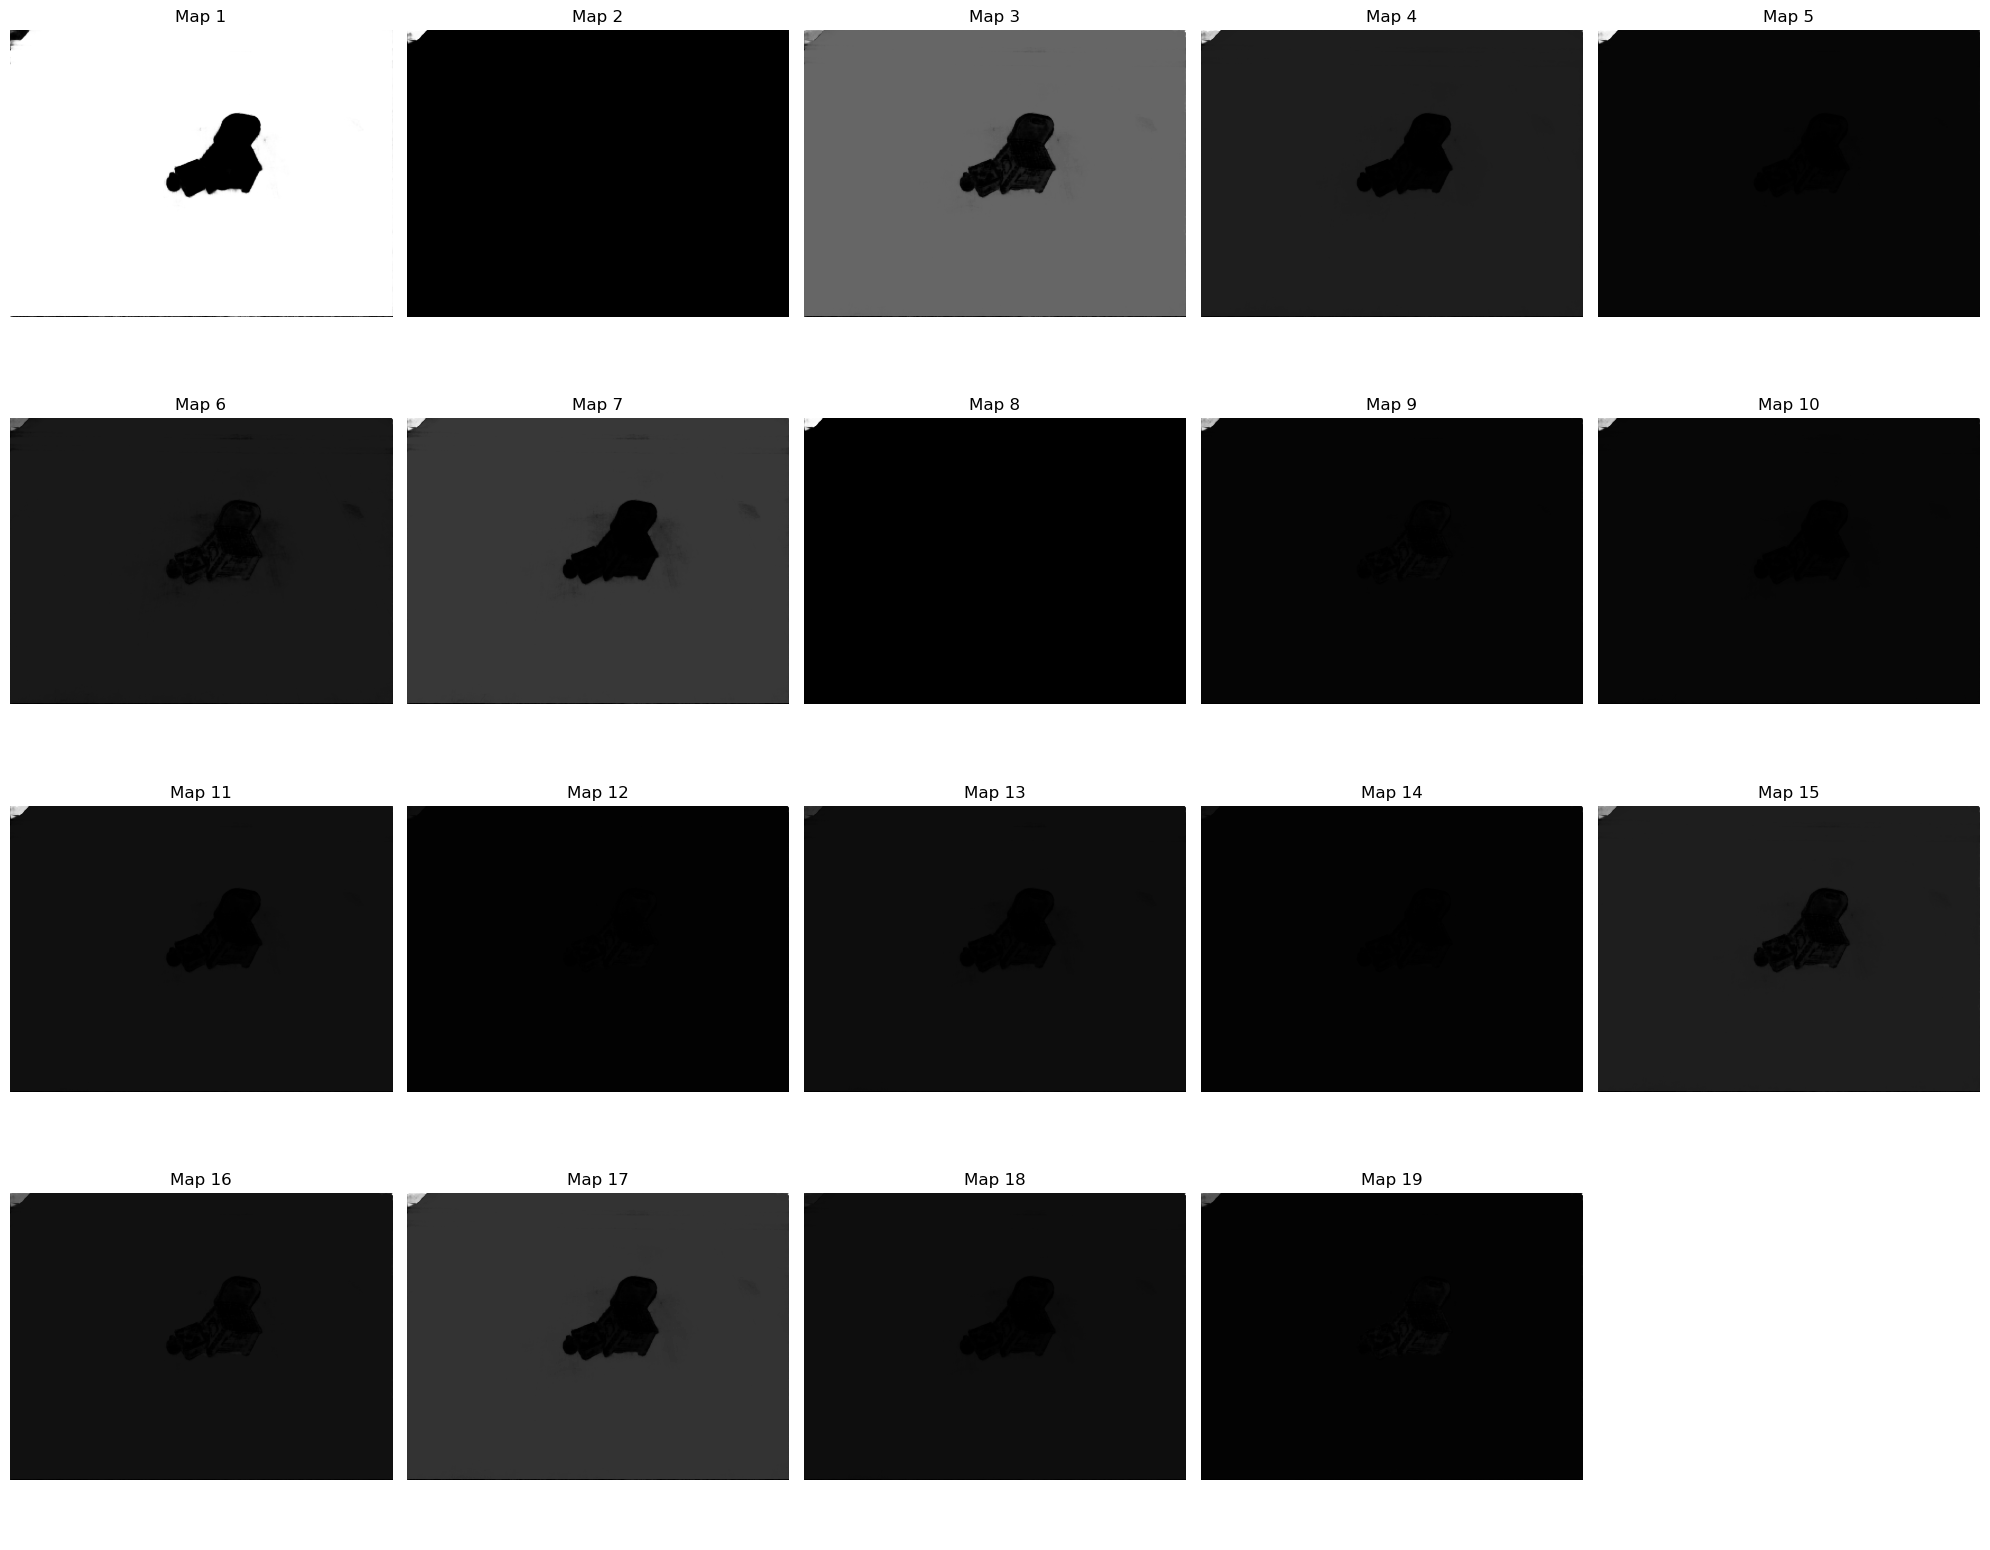

In [9]:
maps_squeezed = anomaly_map.squeeze(0).cpu()  # This slices out the second map

fig, axs = plt.subplots(4, 5, figsize=(20, 16))  # Adjust subplot grid as needed
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < maps_squeezed.shape[0]:
        # Convert the i-th map to numpy and display it
        ax.imshow(maps_squeezed[i].numpy(), cmap='gray')
        ax.set_title(f'Map {i+1}')
        ax.axis('off')
    else:
        # Hide extra subplots if they exist
        ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
import os

results_dir = "./results/cityscapes_ntu6"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Iterate over files in the ./data directory
data_dir = "./data"
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    # Check if it's an image based on its extension (simple filter)
    if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"Processing {filename}...")
        result_image = pred(file_path)  # Apply your function
        
        # Save the result
        result_path = os.path.join(results_dir, filename)
        cv2.imwrite(result_path, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
        print(f"Saved to {result_path}")

Processing IMG_20240226_175718.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175718.jpg
Processing IMG_20240226_175309.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175309.jpg
Processing IMG_20240226_175428.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175428.jpg
Processing IMG_20240226_175820.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175820.jpg
Processing IMG_20240226_175908.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175908.jpg
Processing 20240226193200.jpg...
Saved to ./results/cityscapes_ntu6/20240226193200.jpg
Processing IMG_20240226_180027.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_180027.jpg
Processing IMG_20240226_175221.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175221.jpg
Processing IMG_20240226_175809.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175809.jpg
Processing IMG_20240226_175745.jpg...
Saved to ./results/cityscapes_ntu6/IMG_20240226_175745.jpg
Processing IMG_20240226_175404.jpg...
Sa